# Comparing Randomization Schemes

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from lolopy.learners import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor as SKRFRegressor
from sklearn.datasets import load_boston
import numpy as np
import pandas as pd

## Load the data

In [3]:
header_names=["nRow", "noiseTrain", "noiseTest", "nBag", "jackknife", "recalibration", "rmse", "stdconf", "ucorr", "stdres"]
keys = ["nRow", "nBag", "jackknife", "recalibration", "noiseTrain", "noiseTest"]
metrics = ["rmse", "stdconf", "ucorr", "stdres"]
types = {}
    
def load_data(file):
    df = pd.read_csv(file, header=None, names=header_names, dtype=types)
    grouped = df.groupby(by=keys, as_index=False)
    ans = grouped.mean()
    ans["count"] = grouped.count()[metrics[0]]
    for prop in metrics:
        ans["{} SEM".format(prop)] = np.sqrt(grouped.var()[prop] / (grouped.count()[prop] - 1))
    return ans

dat = load_data("full_data.csv")
avg_corr_jackknife = dat[dat["jackknife"]]["ucorr"].mean()
avg_corr_ensemble = dat[dat["jackknife"] != True]["ucorr"].mean()
print(avg_corr_ensemble, avg_corr_jackknife, avg_corr_ensemble - avg_corr_jackknife)

0.4193549122825911 0.37300208900549126 0.04635282327709983


In [10]:
def make_lc(df, training_noise=0.0, scaling=0, nRow=None):
    fig, axs = plt.subplots(4, 2)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    if nRow == None:
        x = "nRow"
    else:
        x = "nBag"
    
    def extract(sub):
        jk = sub[(sub["jackknife"]) & (sub["recalibration"])]
        es = sub[(sub["jackknife"] != True) & (sub["recalibration"])]
        jk_raw = sub[(sub["jackknife"]) & (sub["recalibration"] != True)]
        return jk, es, jk_raw
        
    def single_plot(ax, jk, es, jk_raw, metric):
        ax.set_xscale('log')

        ax.errorbar(jk[x], jk[metric], yerr=jk[metric + " SEM"], fmt="o-", label="Jackknife", color=colors[0])
        ax.errorbar(es[x], es[metric], yerr=es[metric + " SEM"], fmt="o-", label="Ensemble", color=colors[1])
        ax.errorbar(jk_raw[x], jk_raw[metric], yerr=jk_raw[metric + " SEM"], fmt="o--", label="JK Raw", color=colors[0])
    
    if scaling > 0:
        df = df[(df["nRow"] * scaling == df["nBag"])]
    else:
        if nRow == None:
            df = df[(df["nBag"] == 128)]
        else:
            df = df[(df["nRow"] == nRow)]
    
    sub_pred = df[(df["noiseTrain"] == training_noise) & (df["noiseTest"] == training_noise)].sort_values(by=x)
    sub_conf = df[(df["noiseTrain"] == training_noise) & (df["noiseTest"] == 0.0)].sort_values(by=x)

    jk, es, jk_raw = extract(sub_conf)
    #print(sub_pred)

    single_plot(axs[0][0], jk, es, jk_raw, "rmse")
    single_plot(axs[1][0], jk, es, jk_raw, "stdconf")
    single_plot(axs[2][0], jk, es, jk_raw, "ucorr")
    single_plot(axs[3][0], jk, es, jk_raw, "stdres")
    axs[0][0].legend()
    axs[0][0].set_yscale("log")
    axs[0][0].set_title("Confidence")

    jk, es, jk_raw = extract(sub_pred)
    
    single_plot(axs[0][1], jk, es, jk_raw, "rmse")
    single_plot(axs[1][1], jk, es, jk_raw, "stdconf")
    single_plot(axs[2][1], jk, es, jk_raw, "ucorr")
    single_plot(axs[3][1], jk, es, jk_raw, "stdres")
    axs[0][1].set_yscale("log")
    axs[0][1].set_title("Prediction")
    
    axs[0][0].set_ylabel("RMSE")
    axs[1][0].set_ylabel("Standard Confidence")
    axs[2][0].set_ylabel("Uncertainty Correlation")
    axs[3][0].set_ylabel("Standard Residual")
    axs[3][0].set_xlabel(x)
    axs[1][0].plot([16, max(es[x])], [0.68, 0.68], 'k--')
    axs[1][1].plot([16, max(es[x])], [0.68, 0.68], 'k--')
    axs[3][0].plot([16, max(es[x])], [1.0, 1.0], 'k--')
    axs[3][1].plot([16, max(es[x])], [1.0, 1.0], 'k--')
    

    rmse_min = df["rmse"].min()
    rmse_max = df["rmse"].max()
    print(rmse_min, rmse_max)
    for ax in axs[0]:
        ax.set_ylim(rmse_min*0.8, rmse_max*1.2)
    
    fig.set_size_inches(12, 9)
    fig.tight_layout()
    return fig

0.4423002777777776 2.180349722222223


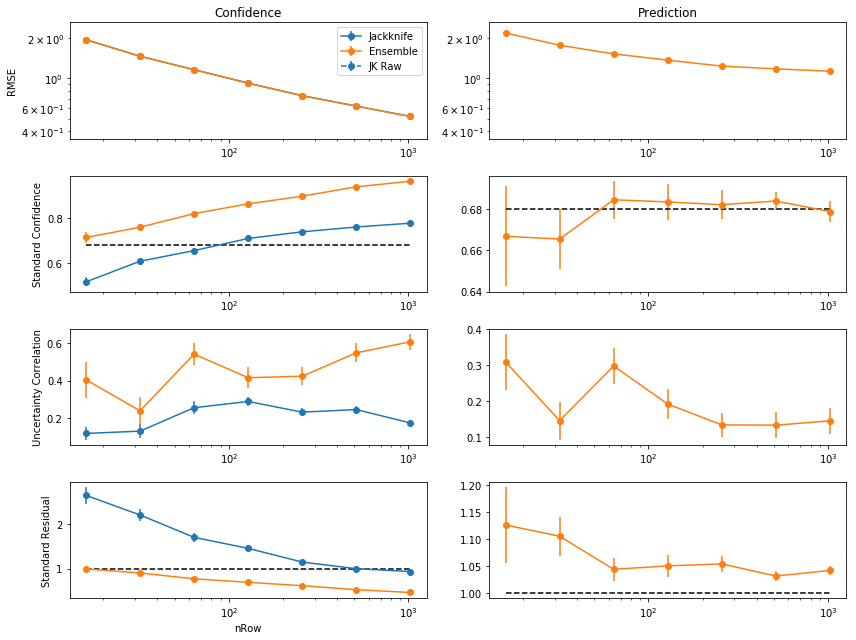

In [60]:
fig = make_lc(load_data("foo.csv"), training_noise=1.0, scaling=4)
# fig.savefig("lc_fs_no-noise.svg")
#load_data("no_floor_data.csv")

In [6]:
load_data("foo.csv")

,nRow,nBag,jackknife,recalibration,noiseTrain,noiseTest,rmse,stdconf,ucorr,stdres,count,rmse SEM,stdconf SEM,ucorr SEM,stdres SEM
0,16,32,False,False,1.0,0.0,0.503407,0.967992,0.258478,0.448564,9,0.043936,0.007020,0.374759,0.022711
1,16,32,False,False,1.0,1.0,1.260041,0.648328,0.175436,1.153314,9,0.025132,0.014453,0.095319,0.044635
2,16,32,False,True,1.0,0.0,0.503407,0.965060,0.258258,0.377590,9,0.043936,0.023894,0.371233,0.064565
3,16,32,False,True,1.0,1.0,1.260041,0.750596,0.174688,0.948512,9,0.025132,0.050308,0.093348,0.125030
4,16,32,True,False,1.0,0.0,0.546048,0.684354,0.152198,1.677444,9,0.051318,0.027848,0.175841,0.218546
5,16,32,True,False,1.0,1.0,1.276243,0.379450,0.081578,3.609811,9,0.029260,0.011164,0.032189,0.213904
6,16,32,True,True,1.0,0.0,0.546048,0.584147,0.151437,2.159779,9,0.051318,0.059487,0.175562,0.250795
7,16,32,True,True,1.0,1.0,1.276243,0.311306,0.081663,4.819453,9,0.029260,0.031046,0.032175,0.593370
8,16,64,False,False,1.0,0.0,0.497259,0.974989,0.220076,0.419606,9,0.050983,0.008154,0.450477,0.026104
9,16,64,False,False,1.0,1.0,1.259696,0.668184,0.192179,1.096784,9,0.028884,0.013003,0.097924,0.038923
